In [1]:
import sys
from pathlib import Path
import soaplite
from soaplite import genBasis
import ase
import ase.io
import numpy as np
from locale import atof
from array import array
import argparse
import os
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor
from tqdm import tqdm

In [2]:
% ls

27Al_process.ipynb*                     Structs/
Alnmr.json*                             Test.ipynb*
DESCRIPTORS_DATA_STRUCTURES_AND_CODES/  Untitled.ipynb*
INCAR/                                  Untitled1.ipynb*
SOAP_test.ipynb*                        periodic_structure_test.txt*
SiO2_structures/                        periodic_test.txt*


In [3]:
incar_dir = 'INCAR'
outcar_dir = 'SiO2_structures'

In [4]:
# get diso and nucleus
nucleus = []
diso = []
for incar_folder in os.listdir(incar_dir):
    for incar in os.listdir(incar_dir+'/'+incar_folder):
        if incar.startswith('SiO2'):
            with open((incar_dir+'/'+incar_folder+'/'+incar+'/'+'ISOCAR'),'r') as f:        
                for line in f.readlines()[7:]:
                    text=line.rstrip('\n').split()
                    nucleus.append(text[0])
                    diso.append(atof(text[1]))
                    #print " %4d %2s %f" % (count,nucleus[-1],diso[-1])            

In [5]:
# get atoms(ase) and structures(pymatgen)
atoms = []
structures = []
for outcar_folder in os.listdir(outcar_dir):
    for outcar in os.listdir(outcar_dir+'/'+outcar_folder):
        atom = ase.io.read(outcar_dir+'/'+outcar_folder+'/'+outcar,format='vasp')
        structure = AseAtomsAdaptor.get_structure(atom)
        atoms.append(atom)
        structures.append(structure)

In [6]:
# get soaps
rCut = 5.5
nMax = 5
lMax=5
soaps = []
for atom in atoms:
    myAlphas, myBetas = genBasis.getBasisFunc(rCut,nMax)
    soap = soaplite.get_periodic_soap_structure(atom, myAlphas, myBetas, 
                                         rCut=rCut, 
                                         nMax=nMax,
                                         Lmax=lMax,
                                         )
    soaps.extend(soap)  
soaps = np.array(soaps)
soaps.shape

(35640, 270)

In [7]:
# get gaussian symmetry fnx (BPSF)
from matminer.featurizers.site import GaussianSymmFunc
gaussiansym = GaussianSymmFunc(etas_g2=[0.000357,0.003214,0.0028569,0.124980,1.428426],
                              etas_g4=[0.000357,0.003214,0.0028569,0.124980,1.428426],
                              zetas_g4=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],
                              gammas_g4=[1.0,-1.0],
                              cutoff=5.5)
gaussiansym.feature_labels()

gaussian_sym = []
for structure in tqdm(structures):
    for idx in range(len(structure)):
        gaussian_sym_single = gaussiansym.featurize(structure,idx)
        gaussian_sym.append(gaussian_sym_single)
gaussian_sym = np.array(gaussian_sym)
gaussian_sym.shape

100%|██████████| 99/99 [22:53<00:00, 12.61s/it]


(35640, 105)

In [10]:
y = soaps #Or something else

In [11]:
result = zip(nucleus,diso,y)
result = pd.DataFrame(result,columns=['nucleus','diso','features'])
y = result[result['nucleus']=='Si']['diso']
X = result[result['nucleus']=='Si']['features']
X = pd.DataFrame(list(X))

In [12]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
from sklearn.linear_model import RidgeCV
alphas = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
clf = RidgeCV(alphas= alphas,cv=10,).fit(X_train, y_train)

In [14]:
print(clf.alpha_)
clf.score(X_test,y_test)

1e-06


0.9597801921678631

### Redge regression

In [15]:
# Grid Search for Algorithm Tuning
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# create and fit a ridge regression model, testing each alpha
model = Ridge(normalize=True,copy_X=True )
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas),scoring='r2',cv=10)
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)
0.9652729271953494
1e-08


score:0.9602262834161645


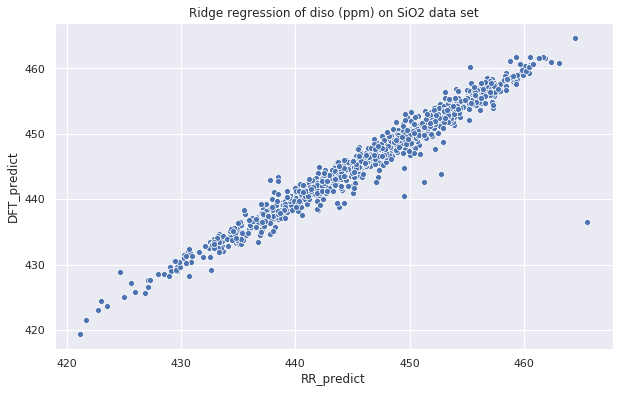

In [16]:
# Predict using kernel ridge
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

y_rr = grid.predict(X_test)

predict_result = pd.DataFrame([y_rr,np.array(y_test)]).transpose().rename(columns={0:'RR_predict',1:'DFT_predict'})
print("score:{}".format(grid.score(X_test,y_test)))

plt.figure(figsize=[10,6])
plt.title('Ridge regression of diso (ppm) on SiO2 data set')
plot = sns.scatterplot(x="RR_predict", y="DFT_predict", data=predict_result)
plt.show()

### Kernel redge regression

In [17]:
# Grid Search for Algorithm Tuning
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
# create and fit a kernel ridge regression model
model = KernelRidge()
param = {'alpha':[1e0, 1e-1, 1e-2, 1e-3],
        'kernel':['linear','rbf']}
grid = GridSearchCV(estimator=model, param_grid=param,scoring='r2',cv=10)
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)
0.9608111639262408
0.001


In [18]:
grid.best_estimator_

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

score:0.9569536388048062


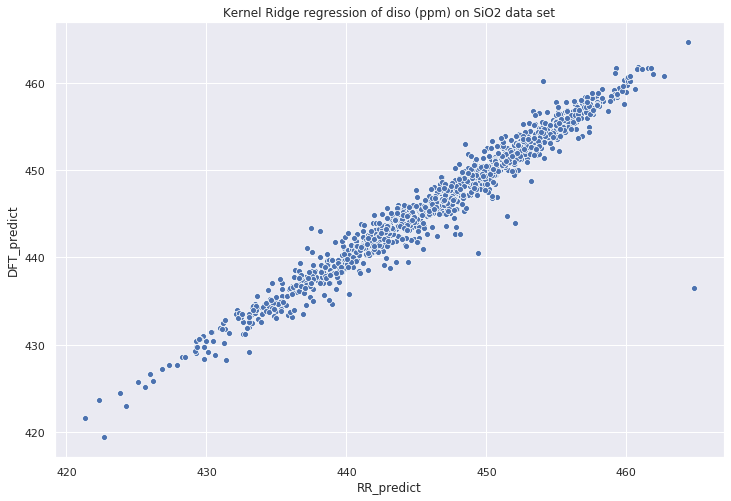

In [19]:
# Predict using kernel ridge
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

y_rr = grid.predict(X_test)

predict_result = pd.DataFrame([y_rr,np.array(y_test)]).transpose().rename(columns={0:'RR_predict',1:'DFT_predict'})
print("score:{}".format(grid.score(X_test,y_test)))

plt.figure(figsize=[12,8])
plt.title('Kernel Ridge regression of diso (ppm) on SiO2 data set')
plot = sns.scatterplot(x="RR_predict", y="DFT_predict", data=predict_result)
plt.show()